In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
# loading arabicWord2vec model 
from gensim.models  import Word2Vec
sg_ar_twitter_100 =Word2Vec.load("/content/drive/My Drive/OffensEval 2020/Data/embeddings_skip_grams_100/full_grams_sg_100_twitter.mdl")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
import re 
import codecs
def read_data(file_path):
  X = []
  Y = []
  pos_num=0
  neg_num=0
  file1= codecs.open(file_path, 'r', 'utf-8')
  for line in file1:
    if line == "nan" or line == "\n":
      continue
    out = line.split(',')
    X.append(out[0])
    label=out[1]
    if "OFF" in label:
      Y.append(1)
      pos_num+=1
    else:
      Y.append(0)
      neg_num+=1

  return X,Y, pos_num, neg_num# # read data test
 
x_train, y_train, pos_num, neg_num = read_data('/content/drive/My Drive/OffensEval 2020/Data/offensive_eval_subtask_A/taskA_cleaned_train_file1.txt')
print(len(y_train))
x_val, y_val, pos_num1, neg_num1 = read_data('/content/drive/My Drive/OffensEval 2020/Data/offensive_eval_subtask_A/taskA_cleaned_validation_file1.txt')
print(len(y_val))

6840
1001


In [4]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
 

def on_hot_vector(X_train , X_val ):
  vocab_size = 50000
  embedding_dim =100
  X_train=[one_hot(d, vocab_size) for d in  X_train]
  X_val= [one_hot(d, vocab_size) for d in  X_val]
  #print(x_train)
  # pad documents to a max length of 4 words
 
  X_train = pad_sequences(X_train, maxlen=max_len,truncating='post', padding='post', value = 0)
  X_val = pad_sequences(X_val, maxlen=max_len,truncating='post', padding='post', value = 0)
  return X_train , X_val , vocab_size , max_len ,embedding_dim



x_train , x_val , vocab_size , max_len , embedding_dim= on_hot_vector(x_train,x_val)

NameError: ignored

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

def create_embedding_matrix(model, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    i=0
    for word in word_index: 
      try :
        idx = word_index[word]
        word_vector = model.wv[word]
        embedding_matrix[idx] = np.array(
                      word_vector, dtype=np.float32)[:embedding_dim]
      
      except KeyError:
        embedding_matrix[idx]=np.random.normal(0,np.sqrt(0.25),embedding_dim)
  

    return embedding_matrix

def word2vec_feature(X_train , X_val):
  tokenizer = Tokenizer(num_words=30000, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
  tokenizer.fit_on_texts(X_train)
  X_train = tokenizer.texts_to_sequences(X_train)
  X_val = tokenizer.texts_to_sequences(X_val)
  vocab_size = len(tokenizer.index_word) + 1 
  embedding_matrix = create_embedding_matrix(sg_ar_twitter_100, tokenizer.word_index,100)
  max_len =50
  x_train = pad_sequences(X_train, maxlen=max_len,truncating='post', padding='post', value = 0)
  x_val = pad_sequences(X_val, maxlen=max_len,truncating='post', padding='post', value = 0)
  return x_train , x_val, vocab_size , embedding_matrix , max_len

x_train , x_val  , vocab_size , embedding_matrix , max_len= word2vec_feature(x_train, x_val)

 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
def feature_extration_tfidf(X_train , X_val):
  # feature Extraction 
# Tfidf extration

  vectorizer = TfidfVectorizer()
  X_train = vectorizer.fit_transform(X_train) 
  X_val = vectorizer.transform(x_val)
 
  return X_train , X_val


x_train , x_val = feature_extration_tfidf(x_train, x_val )

In [0]:
def feature_extraction_bow(X_train,X_test):
  count_vec = CountVectorizer()
  X_train = count_vec.fit_transform(X_train) 
  X_test = count_vec.transform(X_test)
  print(X_train.shape)
  print(X_test.shape)

  return X_train , X_test

X_train , X_test = feature_extraction_bow(X_train, X_test )

In [0]:
def feature_extraction_Hashing(X_train,X_test):
  FH =HashingVectorizer()
  X_train = FH.fit_transform(X_train) 
  X_test = FH.transform(X_test)
  print(X_train.shape)
  print(X_test.shape)
 
  return X_train , X_test

X_train , X_test = feature_extraction_Hashing(X_train, X_test )

In [0]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Bidirectional
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
##############
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, merge, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

In [0]:
# model for one Hot vectoring embedding 
def create_model_one_hot(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):  
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen))
  model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
  model.add(Dense(30 , activation = 'relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy',precision_m, recall_m, f1_m])
  return model

 
 

In [0]:
# Model For word2vec Embedding
def create_model_word2vec(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):  
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],input_length=maxlen , trainable =True))
  model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
  model.add(Dense(30 , activation = 'relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy',precision_m, recall_m, f1_m])
  return model


In [0]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
 
from keras.layers import Dense, Dropout, Activation
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras import layers
from keras import metrics
def creat_model_cnn(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
  model = Sequential()
  # embedding layer
  model.add(Embedding(vocab_size, embedding_dim,weights=[embedding_matrix],input_length=maxlen , trainable =True))
  # dropout layer
  model.add(Dropout(0.2))
  # convolutional layer 
  model.add(Conv1D(64,
                       3,
                       padding='valid',
                       activation='relu',
                       strides=1))
  model.add(GlobalMaxPooling1D())
  model.add(Dense(256))
  model.add(Dropout(0.2))
  model.add(Activation('relu'))
  model.add(Dense(1))
  model.add(Activation('sigmoid'))
  model.summary()
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy',precision_m, recall_m, f1_m])
  return model



In [0]:
# model for Feature Extraction
def creat_model_FE(num_filters, kernel_size, vocab_size, embedding_dim):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=(x_train.shape[1])))
  model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
  model.add(Dense(30 , activation = 'relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy',precision_m, recall_m, f1_m])
  return model

In [23]:
  #model = create_model_word2vec(64 , 5 , vocab_size , 100 , max_len)
  #model = create_model_one_hot(64 , 5 , vocab_size , 100 , max_len)
  model = creat_model_cnn(64 , 5 , vocab_size , 100 , max_len)
  #model =  creat_model_FE(64 , 5 , 50000 , 10 )
  #history = model.fit((x_train).todense(), y_train, validation_data=((x_val).todense(), y_val), batch_size=100, epochs=10,verbose=1)
  history =model.fit(x_train,
                    y_train,
                    validation_data=(x_val, y_val),
                    batch_size = 100,
                    epochs=20)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           2904700   
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 48, 64)            19264     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
activation_3 (Activation)    (None, 256)              

In [24]:
loss, acc, precesion, recall, f1= model.evaluate(x_val, y_val)
print("Loss: ",loss)
print("acc: ",acc)
print("precesion: ",precesion)
print("recall: ",recall)
print("f1: ",f1)

1001/1001 [==============================] - 0s 103us/step
Loss:  0.5037289384183112
acc:  0.9190809191404642
precesion:  0.859749772093751
recall:  0.626760261756676
f1:  0.7089373248440403


In [25]:
# Best F1_score
from tqdm import tqdm_notebook, tnrange
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from torch.optim.optimizer import Optimizer
import numpy as np


def bestThresshold(y_train,train_preds):
    tmp = [0,0,0] # idx, cur, max
    delta = 0
    for tmp[0] in tqdm(np.arange(0.1, 0.501, 0.01)):
        tmp[1] = f1_score(y_train, np.array(train_preds)>tmp[0])
        if tmp[1] > tmp[2]:
            delta = tmp[0]
            tmp[2] = tmp[1]
    print('best threshold is {:.4f} with F1 score: {:.4f}'.format(delta, tmp[2]))
    return delta , tmp[2]
  
valid= model.predict(x_val)

t=[ i[0] for i in valid] 
delta, _ = bestThresshold(y_val,t)

'''
max_len = 20  - > f1_score = 0.7633
----
with max_len = 30 -> f1_score = 0.7738
'''


best threshold is 0.1000 with F1 score: 0.7831


'\nmax_len = 20  - > f1_score = 0.7633\n----\nwith max_len = 30 -> f1_score = 0.7738\n'

In [0]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
def plot_confusion_matrix(y_test,y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  clf_report = classification_report(y_test, y_pred, target_names=classes, output_dict=True)
  # .iloc[:-1, :] to exclude support
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True) 

In [0]:
 
def predict_with_best_threshold(y_predict , threshold):
  predict=[]
  for i in range(len(y_predict)):
    if y_predict[i] >= threshold :
      predict.append(1)
    else :
      predict.append(0)
  return predict

 

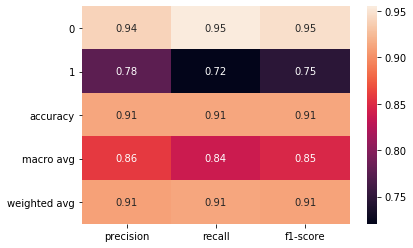

In [21]:
# word2vec
predicted=model.predict(x_val)
pre = predict_with_best_threshold(predicted ,delta  )
plot_confusion_matrix(y_val, pre, classes=list(set(y_val)))

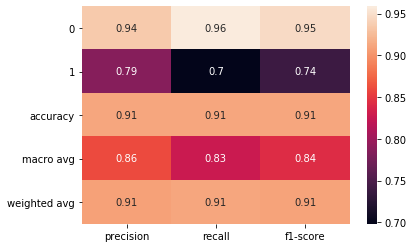

In [19]:
plot_confusion_matrix(y_val, predicted.round(), classes=list(set(y_val)))
 

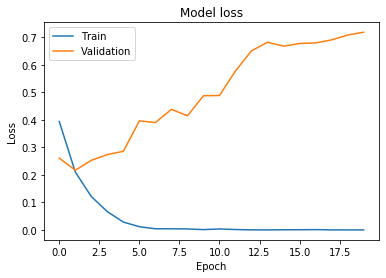

In [23]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

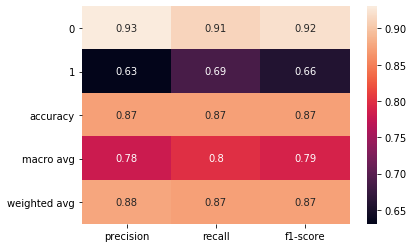

In [36]:
# doc2vec
predicted=model.predict(x_val)
pre = predict_with_best_threshold(predicted ,delta  )
plot_confusion_matrix(y_val, pre, classes=list(set(y_val)))

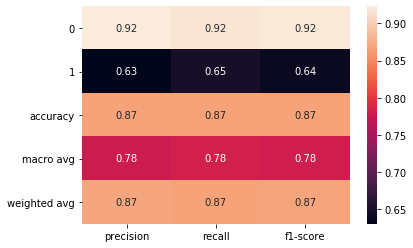

In [37]:
plot_confusion_matrix(y_val, predicted.round(), classes=list(set(y_val)))
 

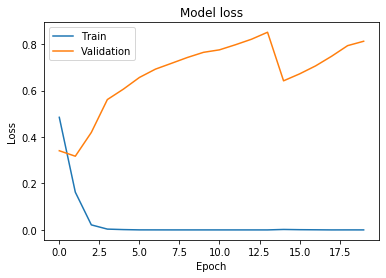

In [38]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

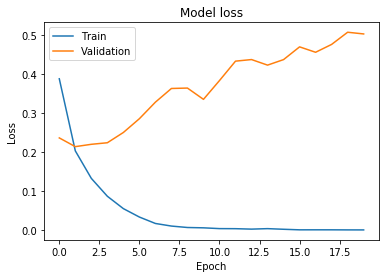

In [28]:
#word2vec_cnn 
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

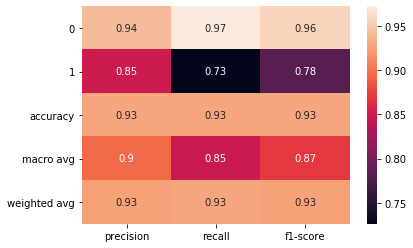

In [29]:
predicted=model.predict(x_val)
pre = predict_with_best_threshold(predicted ,delta)
plot_confusion_matrix(y_val, pre, classes=list(set(y_val)))

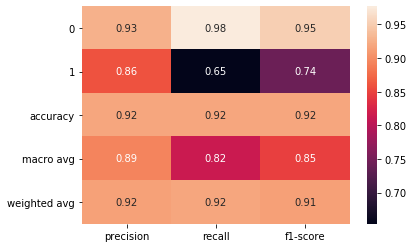

In [30]:
plot_confusion_matrix(y_val, predicted.round(), classes=list(set(y_val)))
 